**Otus Neural Networks**

January 2020
# Домашнее задание #5 *(Необязательное)*
**Сверточные сети**
1. Реализовать сверточный автокодировщик
2. Сделать оптимизацию изображения под активацию сверточных нейронов классификатора
3. Сделать оптимизацию изображения под активацию сверточных нейронов автокодировщика


# 0. Подготовка

In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print("TF version:",tf.__version__)
from tensorflow.python.client import device_lib
print ('devices:',[x.name for x in device_lib.list_local_devices()])

TF version: 2.0.0
devices: ['/device:CPU:0', '/device:GPU:0']


In [2]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, \
                                    MaxPooling2D, Flatten, Reshape, \
                                    UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

### aux functions

In [5]:
def plot_history_metrics (*args):
    """
    вывод графиков потерь и точности
    по результатам обучения модели TF
    :args: Объект(ы) history
    """
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,3))
    for h in args:
        name = h.model.name
        ax0.plot(h.history['loss'], label = name+' train loss')
        ax0.plot(h.history['val_loss'], label = name+' test loss', linestyle = '--')
        ax0.set_xlabel("epoch")
        ax0.set_ylabel("loss")
        ax0.set_title("Динамика потерь", fontsize=14)
        ax0.legend();
        ax1.plot(h.history['accuracy'], label = name+' train acc')
        ax1.plot(h.history['val_accuracy'], label = name+' test acc', linestyle = '--')
        ax1.set_xlabel("epoch")
        ax1.set_ylabel("accuracy")
        ax1.set_title("Динамика точности", fontsize=14)
        ax1.legend();
    names = ', '.join([h.model.name for h in args])
    plt.suptitle(f"Метрики обучения моделей: {names}", fontsize=18, y=1.05)

In [6]:
def plot_mnist(images, shape=None, show_numbers=False, cmap=plt.cm.viridis):
    """выводит на дисплей группу изображений из датасета MNIST
    исходный вариант доработан для гибкости в размере и гамме"""
       
    if shape is None:
        shape = (images.shape[0]//16+1, 
                 max(5, min(images.shape[0], 16)))
    
    fig = plt.figure(figsize=(shape[1]+2,shape[0]+show_numbers), dpi=80)
    for k in range (min(len(images), shape[0]*shape[1])):
        ax = fig.add_subplot(shape[0], shape[1], k+1)
        ax.matshow(images[k], cmap = cmap)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if show_numbers:
            ax.set_xlabel(k)
    plt.show()

## load data

In [7]:
def load_mnist(shape=784):
    """
    Загрузка и предобработка датасета MNIST
    :param shape: целевая размерность датасета
    :return: подготовленный датасет
    """
    (X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
    X_train = X_train / 255.
    X_test = X_test / 255.
    return (X_train, Y_train), (X_test, Y_test)

In [8]:
(X_train, y_train), (X_test, y_test) = load_mnist()
X_train.shape, y_train.shape, X_train.max(), X_train.min(), y_train[:10]

((60000, 28, 28),
 (60000,),
 1.0,
 0.0,
 array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8))

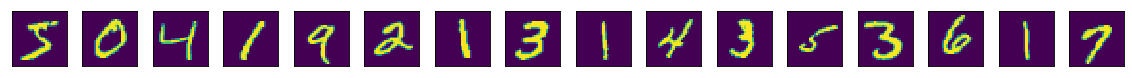

In [9]:
plot_mnist(X_train[:16])

# 1. Classification model

In [10]:
image_shape = (28, 28)
num_classes = 10
input_size = 784
latent_size = 32
output_size = 784

### 1.1. baseline: Модель классификатора с линейными слоями
2 слоя: 100 и 10 нейронов

In [11]:
x = Input(shape=(image_shape), name='input')
x1 = Reshape((input_size,))(x)
z = Dense(100, activation='relu', name='layer1')(x1)
r = Dense(num_classes, activation='softmax', name="sm1")(z)
m0 = Model(x, r, name = 'Linear_Classifier')

m0.compile(optimizer='adam', 
           loss='categorical_crossentropy',
           metrics=['accuracy'])

m0.summary()

Model: "Linear_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
layer1 (Dense)               (None, 100)               78500     
_________________________________________________________________
sm1 (Dense)                  (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [12]:
m0_history = m0.fit(X_train, to_categorical(y_train), 
                    validation_data=(X_test, to_categorical(y_test)),
                    epochs=200,  batch_size=32,
               callbacks=[EarlyStopping(patience=5, min_delta=0.001),])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 5s 85us/sample - loss: 0.2725 - accuracy: 0.9226 - val_loss: 0.1492 - val_accuracy: 0.9574
Epoch 2/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1242 - accuracy: 0.9632 - val_loss: 0.1095 - val_accuracy: 0.9663
Epoch 3/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0871 - accuracy: 0.9742 - val_loss: 0.0860 - val_accuracy: 0.9733
Epoch 4/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0658 - accuracy: 0.9803 - val_loss: 0.0784 - val_accuracy: 0.9773
Epoch 5/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0524 - accuracy: 0.9842 - val_loss: 0.0857 - val_accuracy: 0.9756
Epoch 6/200
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0425 - accuracy: 0.9875 - val_loss: 0.0822 - val_accuracy: 0.9756
Epoch 7/200
60000/60000 [=========================

###  1.2 Модель классификатора со свёрточными слоями
добавлено 2 слоя свёртки + MaxPooling

In [13]:
model_cl = keras.Sequential(name = "conv_classifier")
model_cl.add(Input(shape=image_shape))
model_cl.add(Reshape((28, 28, 1)))
model_cl.add(Conv2D(32, (3, 3), activation='relu'))
model_cl.add(MaxPooling2D((2, 2)))
model_cl.add(Conv2D(32, (3, 3), activation='relu'))
model_cl.add(MaxPooling2D((2, 2)))
model_cl.add(Flatten())
model_cl.add(Dense(100, activation='relu'))
model_cl.add(Dense(10, activation='softmax'))

model_cl.compile(optimizer='adam',loss='categorical_crossentropy',
           metrics=['accuracy'], )

model_cl.summary()

Model: "conv_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 100)           

In [14]:
mcl_history = model_cl.fit(X_train, to_categorical(y_train), 
                    validation_data=(X_test, to_categorical(y_test)),
                    epochs=200,  batch_size=32,
               callbacks=[EarlyStopping(patience=5, min_delta=0.001),])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 7s 125us/sample - loss: 0.1476 - accuracy: 0.9554 - val_loss: 0.0573 - val_accuracy: 0.9819
Epoch 2/200
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0497 - accuracy: 0.9843 - val_loss: 0.0401 - val_accuracy: 0.9878
Epoch 3/200
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0344 - accuracy: 0.9895 - val_loss: 0.0349 - val_accuracy: 0.9878
Epoch 4/200
60000/60000 [==============================] - 6s 97us/sample - loss: 0.0261 - accuracy: 0.9915 - val_loss: 0.0268 - val_accuracy: 0.9907
Epoch 5/200
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.0295 - val_accuracy: 0.9902
Epoch 6/200
60000/60000 [==============================] - 6s 96us/sample - loss: 0.0150 - accuracy: 0.9952 - val_loss: 0.0304 - val_accuracy: 0.9904
Epoch 7/200
60000/60000 [========================

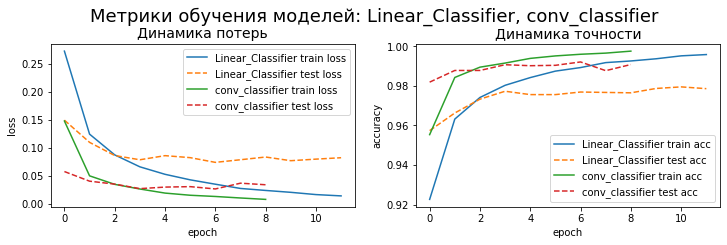

In [15]:
plot_history_metrics (m0_history, mcl_history)

## 2. Модель автокодировщика со свёрткой

In [17]:
image_shape = (28, 28)
num_classes = 10
input_size = 784
latent_size = 32
output_size = 784

In [18]:
"""Encoder"""
model_en = keras.Sequential(name = "Encoder")
model_en.add(Input(shape=image_shape))
model_en.add(Reshape((28, 28, 1)))
model_en.add(Conv2D(32, (3, 3), activation='relu'))
model_en.add(MaxPooling2D((2, 2)))
model_en.add(Conv2D(32, (3, 3), activation='relu'))
model_en.add(MaxPooling2D((2, 2)))
model_en.add(Flatten())
model_en.add(Dense(100, activation='relu'))
model_en.add(Dense(latent_size, activation='sigmoid'))

model_en.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               8010

In [19]:
"""Decoder"""
model_de = keras.Sequential(name = "Decoder")
model_de.add(Input(shape=latent_size))
model_de.add(Dense(100, activation='relu'))
model_de.add(Dense(800, activation='sigmoid'))
model_de.add(Reshape((5, 5, 32)))
model_de.add(UpSampling2D(size=(2, 2)))
model_de.add(Conv2DTranspose(32, (3, 3), activation='relu'))
model_de.add(UpSampling2D(size=(2, 2)))
model_de.add(Conv2DTranspose(1, (3, 3), activation='relu'))
model_de.add (keras.layers.ZeroPadding2D())
model_de.add(Reshape(image_shape))

model_de.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_5 (Dense)              (None, 800)               80800     
_________________________________________________________________
reshape_3 (Reshape)          (None, 5, 5, 32)          0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 1)         289 

In [20]:
model_ae = Model (x, model_de(model_en(x)), name="Convolutional_AE")
model_ae.compile(optimizer='adam', loss='mse')
model_ae.summary()

Model: "Convolutional_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
Encoder (Sequential)         (None, 32)                92900     
_________________________________________________________________
Decoder (Sequential)         (None, 28, 28)            93637     
Total params: 186,537
Trainable params: 186,537
Non-trainable params: 0
_________________________________________________________________


In [21]:
ae_history = model_ae.fit(X_train, X_train, validation_data=(X_test, X_test),
               epochs=200,
               batch_size=200,
               callbacks=[EarlyStopping(patience=5, min_delta=0.001),])

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0420 - val_loss: 0.0242
Epoch 2/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0208 - val_loss: 0.0174
Epoch 3/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0164 - val_loss: 0.0145
Epoch 4/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0143 - val_loss: 0.0129
Epoch 5/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0129 - val_loss: 0.0119
Epoch 6/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0120 - val_loss: 0.0112
Epoch 7/200
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0113 - val_loss: 0.0106
Epoch 8/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0108 - val_loss: 0.0104
Epoch 9/200
60000/60000 [==============================] - 2s 38us/sample - loss: 0.01

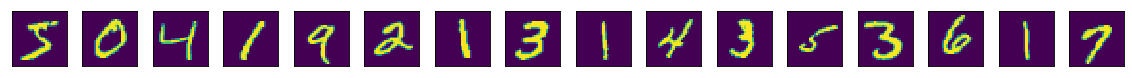

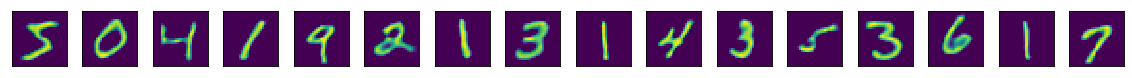

In [22]:
"""Демонстрация работы автокодировщика"""
plot_mnist(X_train[:16])
plot_mnist(model_ae.predict(X_train[:16]))

**Наблюдение:** автокодировщик с 2мя слоями свёртки и латентным слоем в 32 нейрона смог обучиться до уровня потерь MSE 0.0067. Для сравнения однослойный АК с 64 латентными нейронами в прошлом ДЗ обучался только до уровня потерь MSE порядка 0,016

# 3. Поиск изображений для активации отдельных нейронов.

## 3.1 простой способ: через декодер автокодировщика

подаём на вход декодера единичную матрицу и смотрим на результат.

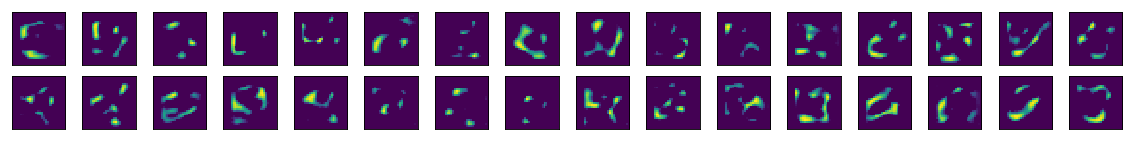

In [24]:
y = np.eye(model_ae.get_layer('Encoder').output.shape[-1])
latent_images_ae = model_ae.get_layer('Decoder').predict(y) 
plot_mnist(latent_images_ae)

уровень ошибки: 0.18508


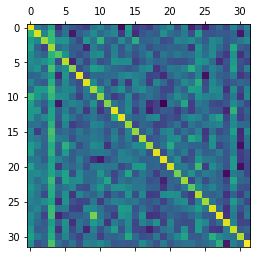

In [25]:
y_hat = model_ae.get_layer('Encoder')(latent_images_ae).numpy()
plt.matshow(y_hat)
y_loss = keras.losses.MSE(y.reshape(-1), y_hat.reshape(-1)).numpy()
print (f"уровень ошибки: {y_loss:.5f}")

## 3.2 Сложный способ: Поиск изображений латентного слоя градиентным спуском

In [26]:
def get_KL(data_rho, rho=0.05):
    """
    расчёт рсахождения Кульбака-Лейбнера
    D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
    взято тут: https://github.com/mishc9/sparse-ae/blob/master/sparse_ae/model.py
    """
    eps = keras.backend.epsilon()  # ближайшее к нулю значение типа float

    dkl = (- rho * tf.math.log(eps + data_rho / (rho + eps))
            - (1 - rho) * tf.math.log(eps + (1 - data_rho) / (1 - rho + eps)))

    return tf.reduce_mean(dkl)

In [27]:
def get_pics(model, max_epochs=200, verbose=20, KL_reg=False, optimizer=keras.optimizers.Adam()):
    """
    градиентный поиск набора входящих изображений, активирующих единичные нейроны.
    :model: обученная модель
    """
    max_loss = 0.001  # for early stopping
    num_input = np.prod(model.input.shape[1:])
    num_output = model.output.shape[-1]
    print(f"Model dimensions. Input:{num_input}, Output/Latent:{num_output}")

    x_ = tf.Variable(tf.random.uniform(
            shape=(num_output, num_input), minval=-10, maxval=10)) # init weights

    y_true=tf.Variable(np.eye(num_output), dtype=tf.float32)

    for e in tqdm(range(max_epochs)):

        with tf.GradientTape() as tape:
            # предсказание y; cигмоида для приведение в диапазон [0,1]
            y_hat=model(tf.math.sigmoid(x_))
            loss=tf.keras.losses.MSE(y_hat, y_true)
            if KL_reg:
                kl_loss=get_KL(tf.math.sigmoid(x_), rho=0.1)
                loss += kl_loss
            else:
                kl_loss=0

        if not e % verbose:
            kl_string=f", KL_loss={kl_loss:.5f}" if KL_reg else ''
            print(f"Epoch:{e}, max_loss:{loss.numpy().max()-kl_loss:.5f}", kl_string)

        grads=tape.gradient(loss, x_)
        optimizer.apply_gradients(zip([grads], [x_]))
        if tf.math.reduce_max(loss) < max_loss:
            break

    final_loss=tf.math.reduce_max(loss)
    print(f"Optimized in {e+1} epochs, loss:{final_loss:.5f}")
    x2=tf.math.sigmoid(x_).numpy().reshape(-1, 28, 28)
    print(f"Result range: min:{x2.min():.3f}, max:{x2.max():.3f}")
    return x2

### поиск градиентным спуском  для модели классификатора

Model dimensions. Input:784, Output/Latent:10


Epoch:0, max_loss:0.19875 
Epoch:1000, max_loss:0.13102 
Epoch:2000, max_loss:0.11461 
Epoch:3000, max_loss:0.00255 
Optimized in 3445 epochs, loss:0.00100
Result range: min:0.000, max:1.000


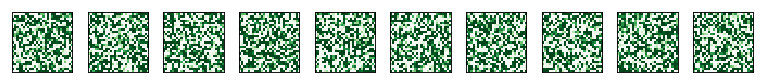

уровень ошибки: 0.00025


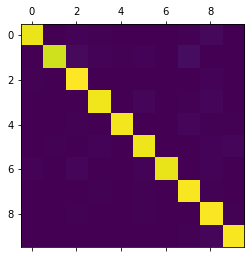

In [28]:
"""поиск латентных изображений без регуляризации"""
x2 = get_pics (model_cl, KL_reg=False, max_epochs=10000, verbose=1000)
plot_mnist(x2, cmap='Greens')

y_hat = model_cl(x2).numpy()
y_loss = tf.math.reduce_mean(keras.losses.MSE(np.eye(10), y_hat)).numpy()
print (f"уровень ошибки: {y_loss:.5f}")
plt.matshow(y_hat);

Model dimensions. Input:784, Output/Latent:10


Epoch:0, max_loss:0.18386 , KL_loss=2.23220
Epoch:2000, max_loss:0.00386 , KL_loss=1.07027
Epoch:4000, max_loss:0.00142 , KL_loss=0.53875
Epoch:6000, max_loss:0.00111 , KL_loss=0.21731
Epoch:8000, max_loss:0.00130 , KL_loss=0.06325
Epoch:10000, max_loss:0.00125 , KL_loss=0.01532
Epoch:12000, max_loss:0.00110 , KL_loss=0.00567
Epoch:14000, max_loss:0.00099 , KL_loss=0.00426
Epoch:16000, max_loss:0.00098 , KL_loss=0.00413
Epoch:18000, max_loss:0.00098 , KL_loss=0.00410

Optimized in 20000 epochs, loss:0.00508
Result range: min:0.030, max:0.596


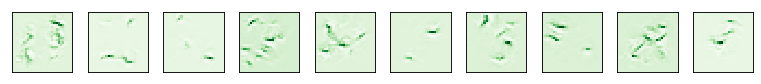

уровень ошибки: 0.00054


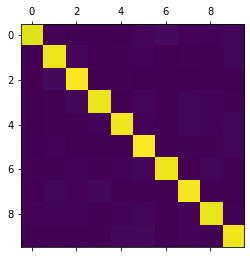

In [29]:
"""поиск латентных изображений c регуляризацией KL"""
x2 = get_pics (model_cl, KL_reg=True, max_epochs=20000, verbose=2000)
plot_mnist(x2, cmap='Greens')

y_hat = model_cl(x2).numpy()
y_loss = tf.math.reduce_mean(keras.losses.MSE(np.eye(10), y_hat)).numpy()
print (f"уровень ошибки: {y_loss:.5f}")
plt.matshow(y_hat);

### поиск градиентным спуском для модели  Автокодировщика

пока модели плохо сходятся ...

Model dimensions. Input:784, Output/Latent:32


Epoch:0, max_loss:0.24897 
Epoch:1000, max_loss:0.12691 
Epoch:2000, max_loss:0.11692 
Epoch:3000, max_loss:0.10711 
Epoch:4000, max_loss:0.10602 
Epoch:5000, max_loss:0.10569 
Epoch:6000, max_loss:0.10446 
Epoch:7000, max_loss:0.10387 
Epoch:8000, max_loss:0.10358 
Epoch:9000, max_loss:0.10305 

Optimized in 10000 epochs, loss:0.10234
Result range: min:0.000, max:1.000


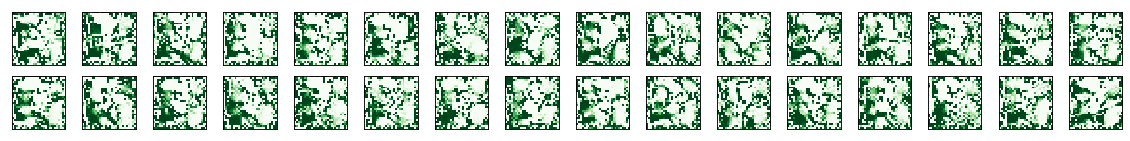

уровень ошибки: 0.08467


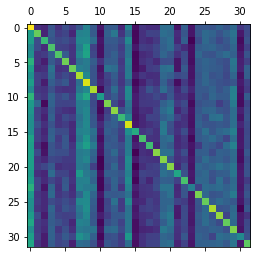

In [30]:
"""поиск латентных изображений без регуляризации"""
x3 = get_pics (model_en, KL_reg=False, max_epochs=10000, verbose=1000, optimizer=keras.optimizers.Adam(lr=0.01))
plot_mnist(x3, cmap='Greens')

y_hat = model_en(x3).numpy()
y_loss = tf.math.reduce_mean(keras.losses.MSE(np.eye(32), y_hat)).numpy()
print (f"уровень ошибки: {y_loss:.5f}")
plt.matshow(y_hat);

Model dimensions. Input:784, Output/Latent:32


Epoch:0, max_loss:0.25788 , KL_loss=2.25657
Epoch:1000, max_loss:0.18365 , KL_loss=0.07020
Epoch:2000, max_loss:0.16582 , KL_loss=0.02930
Epoch:3000, max_loss:0.16188 , KL_loss=0.02947
Epoch:4000, max_loss:0.15840 , KL_loss=0.02956
Epoch:5000, max_loss:0.15840 , KL_loss=0.02958
Epoch:6000, max_loss:0.15838 , KL_loss=0.02958
Epoch:7000, max_loss:0.15838 , KL_loss=0.02957
Epoch:8000, max_loss:0.15844 , KL_loss=0.02957
Epoch:9000, max_loss:0.15843 , KL_loss=0.02957

Optimized in 10000 epochs, loss:0.18798
Result range: min:0.026, max:0.872


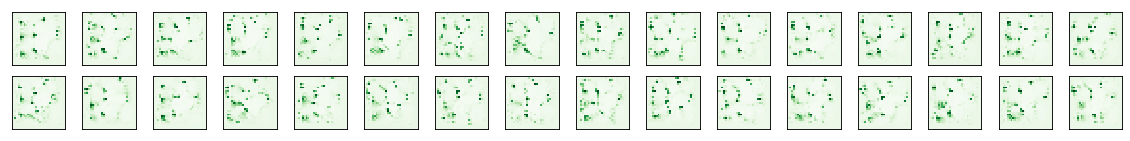

уровень ошибки: 0.14662


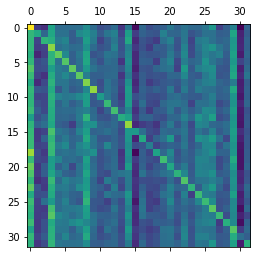

In [31]:
"""поиск латентных изображений c регуляризацией KL"""
x2 = get_pics (model_en, KL_reg=True, max_epochs=10000, verbose=1000, optimizer=keras.optimizers.Adam(lr=0.01))
plot_mnist(x2, cmap='Greens')

y_hat = model_en(x2).numpy()
y_loss = tf.math.reduce_mean(keras.losses.MSE(np.eye(32), y_hat)).numpy()
print (f"уровень ошибки: {y_loss:.5f}")
plt.matshow(y_hat);

## 3.3 Красивый способ.<br>Усреднение скрытых представлений автокодировщика<br>для получения идеальных изображений

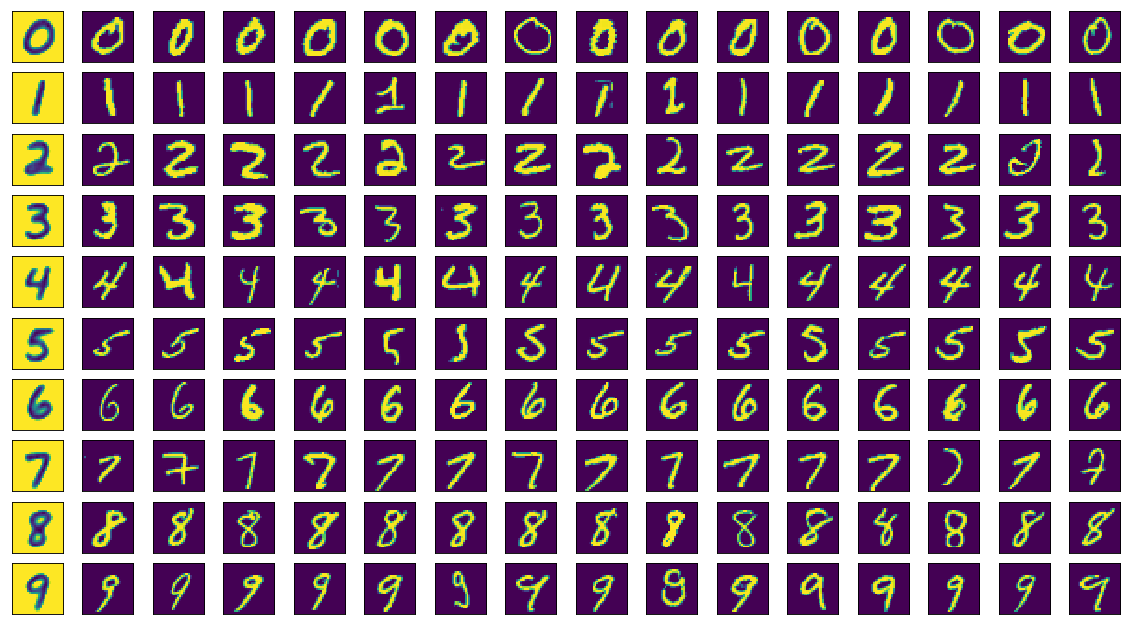

In [32]:
perfect_digits = []
samples = []
for digit in range(10):
    feed = X_train[y_train == digit]  # выбор изображений нужной цифры
    sample = feed[:16]
    feed = tf.convert_to_tensor(feed, dtype=tf.float32)
    latent_feed = model_en(feed)  # кодирование в латентное пространство
    latent_perfect = tf.math.reduce_mean(latent_feed, axis=0)  # усреднение 
    latent_perfect = tf.expand_dims(latent_perfect, 0).numpy()
    perfect = model_de.predict(latent_perfect)  # декодирование 
    sample[0] = 1 - perfect
    perfect_digits.append(perfect)
    samples.append(sample)
plot_mnist(np.concatenate(samples))

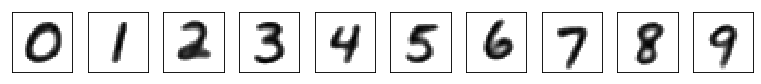

In [33]:
perfect_digits = np.concatenate(perfect_digits)
plot_mnist(1-perfect_digits, cmap='gray')

### Проверка идеальных цифр на модели классификатора:

уровень ошибки: 0.0000000043


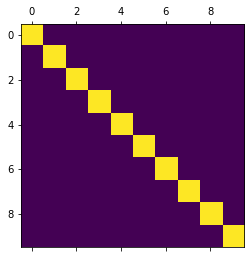

In [34]:
"""на модели со свёртками"""
y_hat = model_cl(perfect_digits)
y_loss = tf.math.reduce_mean(keras.losses.MSE(np.eye(10), y_hat)).numpy()
print (f"уровень ошибки: {y_loss:.10f}")
plt.matshow(y_hat);

уровень ошибки: 0.0000000001


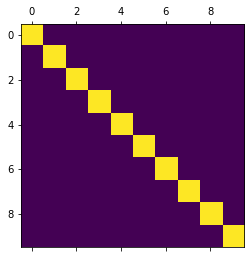

In [35]:
"""на двуслойной модели без свёрток"""
y_hat = m0(perfect_digits)
y_loss = tf.math.reduce_mean(keras.losses.MSE(np.eye(10), y_hat)).numpy()
print (f"уровень ошибки: {y_loss:.10f}")
plt.matshow(y_hat);